In [1]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from torch.utils.data import DataLoader

from dataset import TrainData, TrainDataset
from processing import calculate_contour

In [2]:
input_dir = "../salt/input"
output_dir = "."
img_size_original = 101
image_size_target = 128
batch_size = 32

In [ ]:
train_data = TrainData(input_dir)

In [ ]:
df = train_data.train_set_df

In [ ]:
train_set = TrainDataset(df, image_size_target, augment=True)
train_set_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Data augmentations

In [ ]:
nrows = 10
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(20, int(nrows / ncols) * 20))
for r in range(nrows):
    original_image = df.images[r]
    original_mask = df.masks[r]
    original_mask_contours = calculate_contour(original_mask)
    axs[r, 0].imshow(original_image, cmap="gray")
    axs[r, 0].imshow(original_mask, cmap="Greens", alpha=0.3)
    axs[r, 0].imshow(original_mask_contours, cmap="Reds", alpha=0.3)
    axs[r, 0].set_xticklabels([])
    axs[r, 0].set_yticklabels([])
    for c in range(1, ncols):
        train_item = train_set[r]
        augmented_image = train_item[0]
        augmented_mask = train_item[1].squeeze()
        augmented_mask_contours = calculate_contour(augmented_mask.squeeze())
        axs[r, c].imshow(augmented_image[0], cmap="gray")
        axs[r, c].imshow(augmented_mask, cmap="Greens", alpha=0.3)
        axs[r, c].imshow(augmented_mask_contours, cmap="Reds", alpha=0.3)
        axs[r, c].set_xticklabels([])
        axs[r, c].set_yticklabels([])

# Connected components

In [ ]:
df["components_count"] = df.masks.map(np.array).map(measure.label).map(np.unique).map(len)

In [ ]:
ncols = 8
nrows = 8
ncells = ncols * nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(20, int(20 * nrows / ncols)))
target_ids = df.index[(df.components_count == 2) & (df.coverage_class <= 4)]
random_image_indexes = random.sample(range(len(target_ids)), min(ncells, len(target_ids)))
for i, idx in enumerate(target_ids[random_image_indexes]):
    image = df.loc[idx].images
    mask = df.loc[idx].masks
    ax = axs[int(i / ncols), i % ncols]
    ax.imshow(image, cmap="gray")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_original - 1, df.loc[idx].z, color="black")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# GLCM

In [ ]:
ncols = 6
nrows = 10
ncells = ncols * nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(20, int(20 * nrows / ncols)))
target_ids = df.index
random_image_indexes = random.sample(range(len(target_ids)), min(nrows, len(target_ids)))
for i, idx in enumerate(target_ids[random_image_indexes]):
    image = df.loc[idx].images
    mask = df.loc[idx].masks
    glcm_contrast = cv2.imread("../salt/input/train/glcm/contrast-0/{}.png".format(idx))
    glcm_dissimilarity = cv2.imread("../salt/input/train/glcm/dissimilarity-0/{}.png".format(idx))
    glcm_energy = cv2.imread("../salt/input/train/glcm/energy-0/{}.png".format(idx))
    glcm_homogeneity = cv2.imread("../salt/input/train/glcm/homogeneity-0/{}.png".format(idx))
    axs[i, 0].imshow(image, cmap="gray")
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 2].imshow(glcm_contrast, cmap="gray")
    axs[i, 3].imshow(glcm_dissimilarity, cmap="gray")
    axs[i, 4].imshow(glcm_energy, cmap="gray")
    axs[i, 5].imshow(glcm_homogeneity, cmap="gray")
for ax in axs.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [66]:
import cv2
import numpy as np
import pandas as pd

from processing import rldec

test_df = pd.read_csv("./submission_best.csv", index_col="id")
test_df["rle_mask"] = test_df.rle_mask.astype(str)
test_df["masks"] = test_df.rle_mask.map(rldec)

In [92]:
def has_non_salt_inside_salt(mask):
    mask = mask.astype(np.uint8)
    inverted_mask = np.abs(1 - mask)
    nlabels, _, stats, _ = cv2.connectedComponentsWithStats(inverted_mask, 4, cv2.CV_32S)
    for stat in stats[1:]:
        left = stat[cv2.CC_STAT_LEFT]
        top = stat[cv2.CC_STAT_TOP]
        right = left + stat[cv2.CC_STAT_WIDTH]
        bottom = top + stat[cv2.CC_STAT_HEIGHT]
        if left > 0 and top > 0 and right < mask.shape[1] and bottom < mask.shape[0]:
            return True
    return False

uint8
uint8
3
[ 0  0 20]
[5269 4832  100]


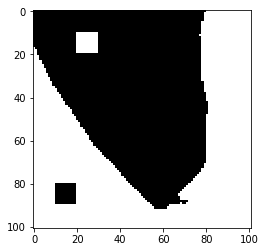

In [91]:
from matplotlib import pyplot as plt

m = test_df.masks[10].copy()

print(test_df.masks[10].dtype)

m[10:20,20:30] = 0
m[80:90,10:20] = 1

has_non_salt_inside_salt(m)

i = np.abs(1 - m)

plt.imshow(i, cmap="gray")

nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(i, 4, cv2.CV_32S)
lbllefts = stats[:, cv2.CC_STAT_LEFT]
lblareas = stats[:, cv2.CC_STAT_AREA]

print(nlabels)
print(lbllefts)
print(lblareas)

In [93]:
test_df["foo"] = test_df.masks.map(has_non_salt_inside_salt)

In [96]:
np.sum(test_df.foo)

198

In [98]:
df = test_df[test_df.foo]

In [99]:
len(df)

198

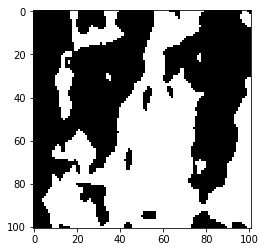

In [105]:
plt.imshow(df.masks[4], cmap="gray")